In [97]:
import numpy as np
from scipy.special import (
    roots_legendre, laguerre, roots_laguerre, legendre, gamma
)
from scipy.optimize import bisect, curve_fit
import scipy.linalg as la
from scipy.stats import linregress
from math import sqrt, sin, cos, log, pi
from numpy import angle
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pandas as pd
from mpmath import mp, coulombf, coulombg
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from scipy.special import legendre
from mpmath import arg

# 1. Método de la matriz-R

El corrimiento de fase 𝛿(𝐸) para el sistema 12C +𝑝
con momento angular 𝑙=0, y funciones de base de tipo Lagrange con N=10 y radio del canal a=8 fm.

In [98]:
N, a = 10, 8

In [99]:
# Constantes físicas
hbar = 197.327                       # MeV*fm
Z1, Z2 = 6, 1
a1, a2 = 12, 1
m1, m2 = 11177.928, 938.27208816     # MeV/c²
mu = (m1 * m2) / (m1 + m2)
cte = hbar**(2)/(2*mu)               # Constante
#cte = 20.736
e2 = 1.44                            # MeV·fm
print(f"hbar**(2)/(2*mu) = {cte:.4f}")

hbar**(2)/(2*mu) = 22.4915


## 1. 1. Potencial
________________________________________________________________________________

Potencial nuclear para el sistema

$$V_N(r) = -73.8\exp(-(r/2.7)^2).$$

Potencial de Coulomb
$$V_C(r) = \frac{6 e^2}{r}$$

Potencial efectivo

$$V_{\rm eff}(r) = -73.8\exp(-(r/2.7)^2) + \frac{6 e^2}{r}$$

In [100]:
# Potenciales
def V_nuclear(r):
    return -73.8 * np.exp(-(r / 2.7) ** 2)
def V_coulomb(r):
    return Z1 * Z2 * e2 / r
def V_total(r):
    return V_nuclear(r) + V_coulomb(r)
def V(r):
    return V_total(r)

print(f"Puntos potencial efectivo")
# Valores potencial
r_vals = np.linspace(1, 5, 5)
V_vals = V(r_vals)
for r, v in zip(r_vals, V_vals):
    print(f"r = {r:.2f} fm, V(r) = {v:.2f} MeV")

Puntos potencial efectivo
r = 1.00 fm, V(r) = -55.70 MeV
r = 2.00 fm, V(r) = -38.31 MeV
r = 3.00 fm, V(r) = -18.59 MeV
r = 4.00 fm, V(r) = -6.06 MeV
r = 5.00 fm, V(r) = -0.66 MeV


### (a) Gráficas

Potencial efectivo


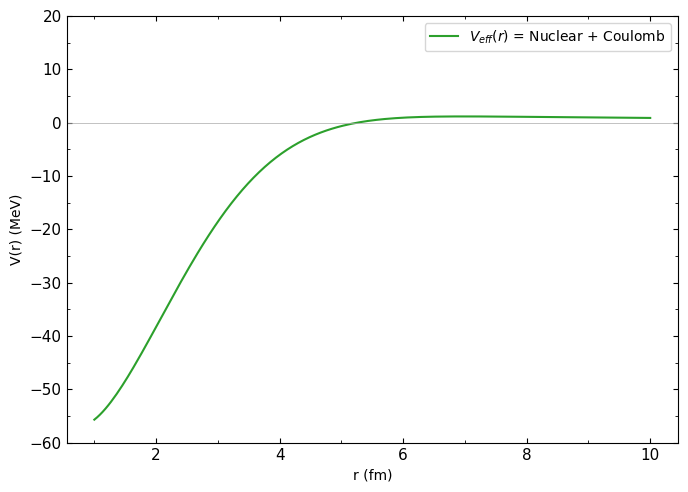

In [101]:
r_vals = np.linspace(1, 10, 200)
V_vals = V(r_vals)
print(f"Potencial efectivo")

# Gráfica
plt.figure(figsize=(7, 5))
plt.plot(r_vals, V_vals, label='$V_{eff}(r)$ = Nuclear + Coulomb', color='#2ca02c')
plt.axhline(0, color='darkgrey', linestyle='-', linewidth=0.5)
plt.xlabel('r (fm)')
plt.ylabel('V(r) (MeV)')
plt.legend()
plt.tight_layout()
# Ejes
plt.ylim(-60, 20)
ax = plt.gca()
for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set_visible(True)
ax.tick_params(
    direction='out',
    bottom=True,
    left=True,
    which='both'
)
ax.tick_params(
    direction='in',
    top=True,
    right=True,
    which='both'
)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.tick_params(labelsize=11)
plt.show()

Potencial nuclear, de Coulomb y efectivo para el sistema


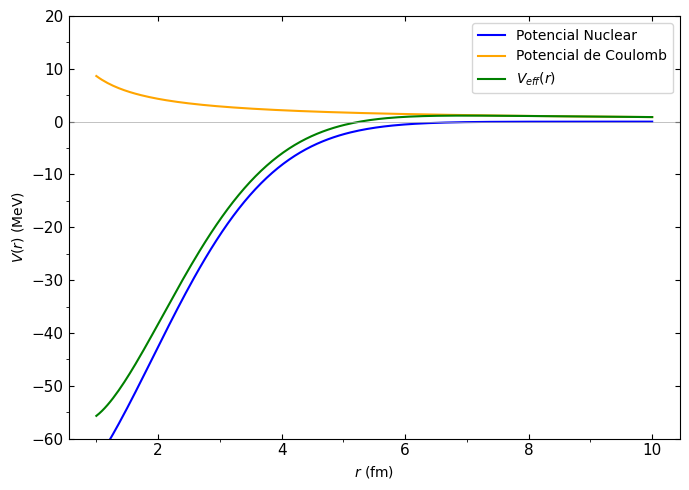

In [102]:
r_vals = np.linspace(1, 10, 200)
# Evaluar potenciales
Vn_vals = V_nuclear(r_vals)
Vc_vals = V_coulomb(r_vals)
Vt_vals = V_total(r_vals)
print(f"Potencial nuclear, de Coulomb y efectivo para el sistema")

# Gráfica
plt.figure(figsize=(7, 5))
plt.plot(r_vals, Vn_vals, label='Potencial Nuclear', color='blue')
plt.plot(r_vals, Vc_vals, label='Potencial de Coulomb', color='orange')
plt.plot(r_vals, Vt_vals, label='$V_{eff}(r)$', color='green')
plt.axhline(0, color='darkgrey', linestyle='-', linewidth=0.5)
plt.xlabel('$r$ (fm)')
plt.ylabel('$V(r)$ (MeV)')
plt.legend()
plt.ylim(-60, 20)
ax = plt.gca()
for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set_visible(True)
ax.tick_params(direction='in', top=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.tick_params(labelsize=11)
plt.tight_layout()
plt.show()

## 1. 2. Funciones de Lagrange-Legendre

**Definir una base de funciones de Lagrange-Legendre** en el intervalo \([0, a]\), con soporte en los nodos de Gauss-Legendre.

$$\tilde{f}_j(x) = (-1)^{N+i} \left( \frac{x}{a x_j} \right) \sqrt{a x_j (1 - x_j)} \frac{P_N\left( \frac{2x}{a} - 1 \right)}{x - a x_j}$$

donde $x_j$ son las raíces del polinomio de Legendre
$𝑃_𝑁(2𝑥_j−1)$.

### (a) Polinomios de Legendre

Las raíces de los polinomios de Legendre $P_n(x)$ son los puntos de cuadratura de Gauss-Legendre: son reales, distintos, y todos están dentro del intervalo $(-1,1)$. Estos polinomios se definen por:

$$P_N(x_j)=\frac{1}{2^N N!}\frac{d^N}{dx_j^N}(x_j^2-1)^N$$

entonces necesitamos hacer un cambio de variable para llevar $[-1,1]$ a $[0,1]$, y usar los puntos $x_i$ que pertenecen a $[0,1]$. El cambio de variable lineal que lleva de $z \in [−1,1]→[a,b]$ es

$$x_j=\frac{b-a}{2}z+\frac{b+a}{2}$$

entonces

$$x_j=1/2(x+1) \rightarrow z=2x_j−1$$

para $[a,b]=[0,1]$. Así, los polinomios de Legendre en el intervalo $[0,1]$, se definen como $P_{n}(x)= \tilde P_{n}(2x_j-1)$.

In [103]:
# Raices polonomios de Legendre ∈ [-1, 1]
z_j, _ = roots_legendre(N)
x_j = 0.5 * (z_j + 1)
x_vals = np.linspace(1e-5, 8, 1000)
P_N = legendre(N)
# Valores raices
print(f"Raíces de polinomios de Legendre para N = {N} y a = {a}")
for i, x in enumerate(x_j):
    print(f"r[{i}] = {x:.6f} fm")

Raíces de polinomios de Legendre para N = 10 y a = 8
r[0] = 0.013047 fm
r[1] = 0.067468 fm
r[2] = 0.160295 fm
r[3] = 0.283302 fm
r[4] = 0.425563 fm
r[5] = 0.574437 fm
r[6] = 0.716698 fm
r[7] = 0.839705 fm
r[8] = 0.932532 fm
r[9] = 0.986953 fm


### (b) Funciones base

Funciones base para N = 10 y a = 8


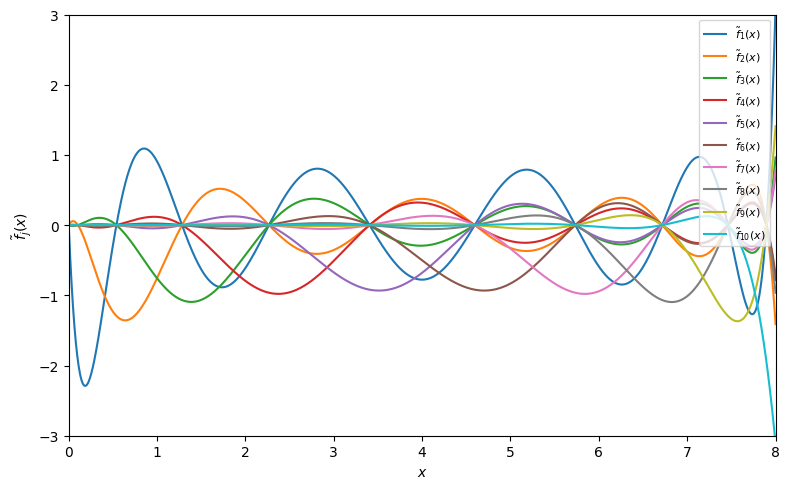

In [104]:
print(f"Funciones base para N = {N} y a = {a}")
# Funciones base - Funciones de Lagrange-Legendre
def f_tilde_j(j, x):
    xj = x_j[j]
    num = (x / (a * xj)) * np.sqrt(a * xj * (1 - xj)) * P_N(2 * x / a - 1)
    den = x - a * xj
    return ((-1) ** (N + j)) * num / den
# Graficar
plt.figure(figsize=(8, 5))
for j in range(N):
    y_vals = f_tilde_j(j, x_vals)
    plt.plot(x_vals, y_vals, label=fr'$\tilde{{f}}_{{{j+1}}}(x)$')
ax.axhline(0, color='darkgrey', linestyle='-', linewidth=0.5)
plt.xlim(0, 8)
plt.ylim(-3, 3)
plt.xlabel(r'$x$')
plt.ylabel(r'$\tilde{f}_j(x)$')
plt.legend(loc='upper right', fontsize=8)
plt.grid(False)
plt.tight_layout()
plt.show()

## 1. 3. Matriz-R
________________________________________________________________________________

**Evaluar la matriz-R** usando la expresión:

$$R_l(E) = \frac{\hbar^2}{2\mu a} \sum_{i,j=1}^{N} \hat{f}_i(a) (C^{-1})_{ij} \hat{f}_j(a),$$

donde $E$ es la energía de colisión, $a$ es el radio del canal, $\hat{f}$ son las funciones regularizadas de Lagrange-Legendre y $C^{-1}$ es la inversa de la matriz $C_{ij}$.

**Construir la matriz Cij**

$$ C_{ij}(E) = \langle \hat{f}_i | T_l + \mathcal{L} + V_{\text{eff}} - E | \hat{f}_j \rangle = \langle \hat{f}_i | T + \mathcal{L} | \hat{f}_j \rangle + (V_{\text{eff}}(ax_i) - E)\delta_{ij}, $$

Para $i = j$:
\begin{align*}
\langle \tilde{f}_i | T + \mathcal{L} | \tilde{f}_i \rangle = \frac{\hbar^2}{2\mu a^2} \cdot \frac{(4N^2 + 4N + 3)x_i(1 - x_i) - 6x_i + 1}{3x_i^2(1 - x_i)^2} \ ,
\end{align*}

Para $i \neq j$:
\begin{align*}
 \langle \tilde{f}_i | T + \mathcal{L} | \tilde{f}_j \rangle = \frac{\hbar^2}{2\mu a^2} &\cdot \frac{(-1)^{i + j}}{\sqrt{x_i x_j (1 - x_i)(1 - x_j)}} \ \times \\
 & \left[ N^2 + N + 1 + \frac{x_i + x_j - 2x_i x_j}{(x_i - x_j)^2} - \frac{1}{1 - x_i} - \frac{1}{1 - x_j} \right] \ .
\end{align*}


### (a) Matriz Cij

**Construcción Matriz Hamiltoniana**

\begin{align*}
\langle \tilde{f}_i | T + \mathcal{L} + V_{eff} | \tilde{f}_i \rangle
\end{align*}

In [105]:
# Matriz Hamiltoniana
def build_hamiltonian(N, a, parity_factor_sign=-1):
    z, w = roots_legendre(N)
    x = 0.5 * (z + 1)        # transformar de [-1,1] a [0,1]
    H = np.zeros((N, N))
    for i in range(N):
        xi = x[i]
        for j in range(N):
            xj = x[j]
            if i == j:
                # Kinetic energy for i=j
                T = ((4 * N**2 + 4 * N + 3) * xi * (1 - xi) - 6 * xi + 1) / (3 * xi**2 * (1 - xi)**2)
                Veff = V(a*xi)
                H[i, j] = cte * T / a**2 + Veff
            else:
                # Kinetic energy for i diferente j
                num1=xi + xj - 2*xi*xj
                deno1=(xi-xj)**2
                par = N**2 + N + 1 + num1/deno1 - (1/(1-xi)) -(1/(1-xj))
                T = (parity_factor_sign ** (i + j)) / (np.sqrt(xi * xj *  (1 - xi) * (1 - xj)) )* par
                H[i, j] = cte * T / a**2
    return H, r, x

Valores de control

In [106]:
H_matriz, r, x = build_hamiltonian(N,a)
print(f"Elementos de matriz H para N = {N} y a = {a}")
#Imprimir algunos elementos
for i in range(4):
    for j in range(4):
     print(f"H_[{i},{j}] = {H_matriz[i,j]:.6f}")

Elementos de matriz H para N = 10 y a = 8
H_[0,0] = 4690.468378
H_[0,1] = -1673.073000
H_[0,2] = 984.252349
H_[0,3] = -773.541972
H_[1,0] = -1673.073000
H_[1,1] = 787.530634
H_[1,2] = -506.606456
H_[1,3] = 358.322168
H_[2,0] = 984.252349
H_[2,1] = -506.606456
H_[2,2] = 333.632848
H_[2,3] = -280.029367
H_[3,0] = -773.541972
H_[3,1] = 358.322168
H_[3,2] = -280.029367
H_[3,3] = 220.929687


### (b) Matriz R

In [107]:
# Polinomio de Legendre de grado N
z_j, _ = roots_legendre(N)
x_j = 0.5 * (z_j + 1)          # en [0, 1]
P_N = legendre(N)
# Función base, Lagrange-Legendre
def f_tilde_j(j, x):
    xj = x_j[j]
    denom = x - a * xj
    denom = denom if np.abs(denom) > 1e-12 else 1e-12  # evitar singularidad
    num = (x / (a * xj)) * np.sqrt(a * xj * (1 - xj)) * P_N(2 * x / a - 1)
    return ((-1) ** (N + j)) * num / denom
# Función f evaluada en r = a
def build_f(N, a):
    f_hat = np.zeros((1, N))
    for j in range(N):
        f_hat[0, j] = f_tilde_j(j, a)
    return f_hat
# Construcción de la matriz R(E)
def build_R_matrix(N, E, H_matriz, f_hat, mu, a):
    C_matrix = H_matriz - E * np.identity(N)
    inv_C = np.linalg.inv(C_matrix)
    R_scalar = (cte / a) * (f_hat @ inv_C @ f_hat.T)[0, 0]
    return R_scalar, C_matrix

Valores de control

In [108]:
E = 2.1
# Hamiltoniano
H_matriz, r, x = build_hamiltonian(N, a)
f_hat = build_f(N, a)
# R y C matriz
R_scalar, C_matrix = build_R_matrix(N, E, H_matriz, f_hat, mu, a)
print(f"Elemento de matriz para N = {N}, a = {a} y E = {E}")
print("\nElementos de H_matriz:")
print(H_matriz[:4, :4])
print("\nElementos de C_matrix:")
print(C_matrix[:4, :4])
print(f"\nTipo de R_scalar: {type(R_scalar)}")      # <class 'float'>
print(f"R = {R_scalar:.6f}\n")

Elemento de matriz para N = 10, a = 8 y E = 2.1

Elementos de H_matriz:
[[ 4690.46837752 -1673.07300022   984.25234857  -773.54197247]
 [-1673.07300022   787.53063355  -506.60645592   358.32216753]
 [  984.25234857  -506.60645592   333.63284839  -280.02936671]
 [ -773.54197247   358.32216753  -280.02936671   220.92968652]]

Elementos de C_matrix:
[[ 4688.36837752 -1673.07300022   984.25234857  -773.54197247]
 [-1673.07300022   785.43063355  -506.60645592   358.32216753]
 [  984.25234857  -506.60645592   331.53284839  -280.02936671]
 [ -773.54197247   358.32216753  -280.02936671   218.82968652]]

Tipo de R_scalar: <class 'numpy.float64'>
R = 0.085126



### (c) Rango de energías

In [109]:
N, a = 10, 8
# Construcción
H_matriz, r, x = build_hamiltonian(N, a)
f_hat = build_f(N, a)
# Rango de energías
E_vals = np.linspace(0.1, 10, 100)
R_vals = []
for E in E_vals:
    R_E, _ = build_R_matrix(N, E, H_matriz, f_hat, mu, a)
    R_vals.append(R_E)
# Imprimir algunos valores
print(f"Valores de R(E) para N = {N}, a = {a}")
for E, R in zip(E_vals[::10], R_vals[::10]):
    print(f"E = {E:.3f}, R(E) = {R:.6f}")

Valores de R(E) para N = 10, a = 8
E = 0.100, R(E) = 19.483160
E = 1.100, R(E) = -0.147832
E = 2.100, R(E) = 0.085126
E = 3.100, R(E) = 0.193411
E = 4.100, R(E) = 0.289095
E = 5.100, R(E) = 0.414821
E = 6.100, R(E) = 0.649662
E = 7.100, R(E) = 1.434052
E = 8.100, R(E) = -5.229140
E = 9.100, R(E) = -0.840517


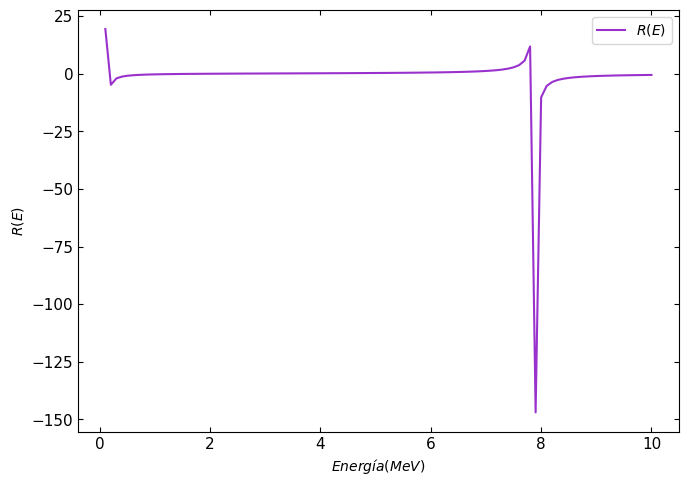

In [110]:
# Graficar
plt.figure(figsize=(7, 5))
plt.plot(E_vals, R_vals, label=r'$R(E)$', color='darkorchid')
plt.xlabel("$Energía (MeV)$")
plt.ylabel("$R(E)$")
plt.tight_layout()
# Ejes
ax = plt.gca()
for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set_visible(True)
ax.tick_params(
    direction='out',
    bottom=True,
    left=True,
    which='both'
)
ax.tick_params(
    direction='in',
    top=True,
    right=True,
    which='both'
)
plt.tick_params(labelsize=11)
plt.legend()
plt.show()

# 1. 4.  Matriz de scaterring
________________________________________________________________________________

La matriz de scattering se calcula como

$$S_l(k) = \frac{H_l^{(-)}(\eta, ka) - akR_l(E)H_l^{(-)'}(\eta, ka)}{H_l^{(+)}(\eta, ka) - akR_l(E)H_l^{(+)'}(\eta, ka)}$$

donde $H^{(\pm)}$ son las funciones de Hankel-Coulomb,

$$H_l^{(+)} = G + iF, \quad \quad $H_l^{(-)} = G - iF$$


con $F_l(\eta, ka) $ la función regular de Coulomb y $G_l(\eta, ka)$ la función irregular de Coulomb. Además

$$\eta = \alpha Z_1 Z_2\sqrt{\mu/(2 E)}, \quad \quad k=\sqrt{2 \mu E}/\hbar$$

con  $k$ es el número de onda y $\eta$ es el parámeto de Sommerfeld.


In [111]:
# Constantes
eta = (1/137) * Z1 * Z2 * np.sqrt(mu / (2 * E))
k = np.sqrt(2 * mu * E) / hbar
ak= a*k
l=0

**Relaciones de recurrencia**

Se definen los siguientes coeficientes

\begin{aligned}
R_\ell = \sqrt{1 + \left( \frac{\eta}{\ell} \right)^2}, \quad\quad
S_\ell = \frac{\ell}{\rho} + \frac{\eta}{\ell}, \quad\quad T_\ell = S_\ell + S_{\ell+1}.
\end{aligned}

Sea $X_\ell(\eta, \rho) = H_\ell^{\pm}(\eta, \rho) $. Entonces, se tienen las siguientes relaciones

\begin{align}
R_\ell X_{\ell - 1} - T_\ell X_\ell + R_{\ell + 1} X_{\ell + 1} &= 0, \quad \quad \text{Relación de recurrencia}
\end{align}
\begin{align}
X_\ell' = S_{\ell + 1} X_\ell - R_{\ell + 1} X_{\ell + 1}, \quad \quad \quad \quad \text{Primera derivada para }l \geq 0
\end{align}

De modo que, la derivada aproximada de la función de Coulomb compleja $H_l^\pm(\rho)$ puede expresarse mediante una relación de recurrencia de la forma
$$ \frac{d}{d\rho}{H_l^\pm(\rho)}{\rho} \approx \left( \frac{l+1}{\rho} + \frac{\eta}{l+1} \right) H_l^\pm(\rho) - \sqrt{1 + \left( \frac{\eta}{l+1} \right)^2 } H_{l+1}^\pm(\rho)
$$


(a) Matriz de scaterring

In [112]:
# --- Funciones de Coulomb tipo Hankel ---
def H(plus, l, eta, ak):
    F = coulombf(l, eta, ak)
    G = coulombg(l, eta, ak)
    return G + 1j * F if plus else G - 1j * F
# Derivada aproximada de H±(ρ)
def H_prime(plus, l, eta, ak):
    S_l_p1 = (l + 1) / (ak) + eta / (l + 1)
    R_l_p1 = np.sqrt(1 + (eta / (l + 1))**2)
    return S_l_p1 * H(plus, l, eta, ak) - R_l_p1 * H(plus, l + 1, eta, ak)
    # Esta fórmula se basa en relaciones de recurrencia de las funciones de Coulomb

# --- Cálculo de S_l ---
def S(plus, l , eta, ak, R_scalar, C_matrix , H, H_prime):
    numerador = H(False, l, eta, ak) - ak * R_scalar * H_prime(False, l, eta, ak)
    denominador = H(True, l, eta, ak) - ak* R_scalar * H_prime(True, l, eta, ak)
    return numerador / denominador

Valor de control

In [113]:
E= 2.1
# Constantes
eta = (1/137) * Z1 * Z2 * np.sqrt(mu / (2 * E))
k = np.sqrt(2 * mu * E) / hbar
ak= a*k
# Hamiltoniano
H_matriz, r, x = build_hamiltonian(N, a)
f_hat = build_f(N, a)
# R(E) y C_matrix
R_scalar, C_matrix = build_R_matrix(N, E, H_matriz, f_hat, mu, a)
# Matriz Sl
S_matriz = S(True, l, eta, ak,  R_scalar, C_matrix, H, H_prime)

print(f"Valores de Sl para N = {N}, a = {a}, l = {l} y E = {E}")
print(f"S_l = {float(S_matriz.real):.6f} + {float(S_matriz.imag):.6f}i")
print(f"|S_l| = {float(abs(S_matriz)):.6f}")

Valores de Sl para N = 10, a = 8, l = 0 y E = 2.1
S_l = -0.535884 + -0.844292i
|S_l| = 1.000000


#### Rango de energías

In [114]:
E_vals = np.linspace(0.1, 10, 100)
R_vals = []
S_vals = []

# Hamiltoniano
H_matriz, r, x = build_hamiltonian(N, a)
f_hat = build_f(N, a)
for E in E_vals:
    eta = (1/137) * Z1 * Z2 * np.sqrt(mu / (2 * E))
    k = np.sqrt(2 * mu * E) / hbar
    ak= a*k
    # R(E) y C_matrix
    R_scalar, C_matrix = build_R_matrix(N, E, H_matriz, f_hat, mu, a)
    R_vals.append(R_scalar)
    # Matriz Sl
    S_E= S(True, l, eta, ak, R_scalar, C_matrix, H, H_prime)
    S_vals.append(S_E)

# Imprimir algunos valores
print(f"Valores de control para N = {N}, a = {a} y l = {l}")
print("\nValores Sl")
# Imprimir algunos valores
for E, S_E in zip(E_vals[::10], S_vals[::10]):
    print(f"E = {E:.3f}, S = {float(S_E.real):.6f} + {float(S_E.imag):.6f}i")

Valores de control para N = 10, a = 8 y l = 0

Valores Sl
E = 0.100, S = 1.000000 + 0.000014i
E = 1.100, S = 0.315782 + -0.948832i
E = 2.100, S = -0.535884 + -0.844292i
E = 3.100, S = -0.938090 + -0.346392i
E = 4.100, S = -0.988398 + 0.151884i
E = 5.100, S = -0.844737 + 0.535182i
E = 6.100, S = -0.612646 + 0.790357i
E = 7.100, S = -0.353384 + 0.935478i
E = 8.100, S = -0.100102 + 0.994977i
E = 9.100, S = 0.130664 + 0.991427i


# 1. 5.  Corrimientos de fase
________________________________________________________________________________

Obtenemos el corrimiento de fase $\delta_l$, despejando la relación \\

$$S_l = e^{i2\delta_l}, \quad \quad S_l = |S| e^{i\theta} $$

con $|S|=1$. Entonces,

$$ \delta_l = \frac{1}{2} arg(S_l) = \frac{1}{2} tan^{-1} \left(\frac{Im \ S_l}{Re \ S_l}\right)$$

In [115]:
S_l = S(True, l, eta, ak, R_scalar, C_matrix, H, H_prime)
delta_l = 0.5 * arg(S_l)
if delta_l < 0:
    delta_l += np.pi

Valor de control

In [116]:
E=2.1
# Hamiltoniano
H_matriz, r, x = build_hamiltonian(N, a)
f_hat = build_f(N, a)
# R y C
R_scalar, C_matrix = build_R_matrix(N, E, H_matriz, f_hat, mu, a)
# Constantes
eta = (1/137) * Z1 * Z2 * np.sqrt(mu / (2 * E))
k = np.sqrt(2 * mu * E) / hbar
ak= a*k
# S_l y δ_l
S_l     = S(True, l, eta, ak, R_scalar, C_matrix, H, H_prime)
delta_l = 0.5 * arg(S_l)
if delta_l < 0:
    delta_l += np.pi
# Mostrar resultados
print(f"Valores de control para N = {N}, a = {a} y l = {l} ")
print(f"E = {E:.3f} MeV, δ_{l} = {np.degrees(float(delta_l)):.6f}°")

Valores de control para N = 10, a = 8 y l = 0 
E = 2.100 MeV, δ_0 = 118.798057°


### (a) Rango de energías

In [117]:
# Rango de energías
E_vals = np.linspace(1e-4, 2.1, 100)
R_vals = []
S_vals = []
delta_vals = []

# Construcción fija
H_matriz, r, x = build_hamiltonian(N, a)
f_hat = build_f(N, a)
for E in E_vals:
    k = np.sqrt(2 * mu * E) / hbar
    eta = (1 / 137) * Z1 * Z2 * np.sqrt(mu / (2 * E))
    ak = a * k
    # R(E) y C_matrix
    R_scalar, C_matrix = build_R_matrix(N, E, H_matriz, f_hat, mu, a)
    # S_l(E)
    S_E = S(True, l, eta, ak, R_scalar, C_matrix, H, H_prime)
    S_vals.append(S_E)
    R_vals.append(R_scalar)
    # δ_l
    delta_l = 0.5 * arg(S_E)
    if delta_l < 0:
       delta_l += np.pi
    delta_vals.append(delta_l)

# Imprimir algunos valores
print(f"Valores de control para N = {N}, a = {a} y l = {l}")

print("\nValores de control para δ_l(E) en grados:")
for E, delta_l in zip(E_vals[::11], delta_vals[::11]):
    print(f"E = {E:.3f} MeV, δ_l = {np.degrees(float(delta_l)):.6f}°")

Valores de control para N = 10, a = 8 y l = 0

Valores de control para δ_l(E) en grados:
E = 0.000 MeV, δ_l = 0.000000°
E = 0.233 MeV, δ_l = 0.325403°
E = 0.467 MeV, δ_l = 144.259426°
E = 0.700 MeV, δ_l = 155.422092°
E = 0.933 MeV, δ_l = 149.120751°
E = 1.167 MeV, δ_l = 142.261297°
E = 1.400 MeV, δ_l = 135.720997°
E = 1.633 MeV, δ_l = 129.639493°
E = 1.867 MeV, δ_l = 124.011792°
E = 2.100 MeV, δ_l = 118.798057°


# 1. 6.  Gráficas
________________________________________________________________________________

Valor de N = 10, a= 8 y l = 0


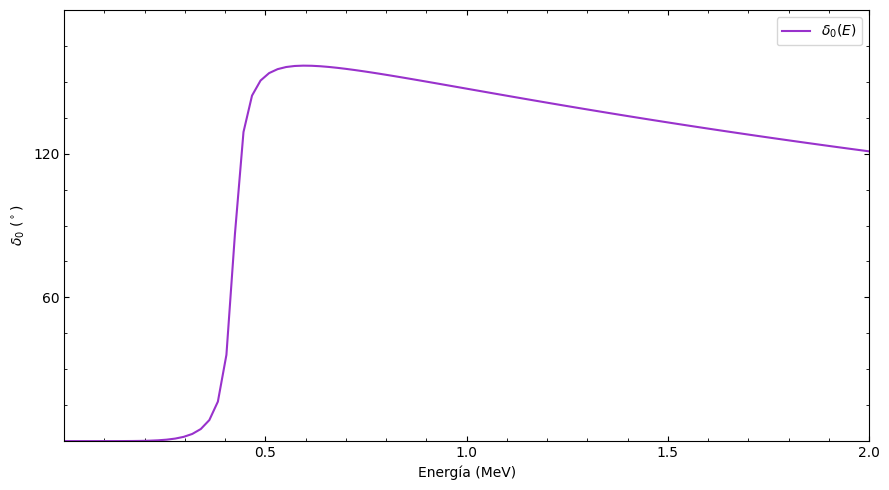

In [118]:
print(f"Valor de N = {N}, a= {a} y l = {l}")
delta_deg = [np.degrees(float(d)) for d in delta_vals]  # convertir a grados
plt.figure(figsize=(9, 5))
plt.plot(E_vals, delta_deg, label=r'$\delta_0(E)$', color='darkorchid')
plt.xlabel("Energía (MeV)")
plt.ylabel(r"$\delta_0$ ($^\circ$)")
plt.xticks(np.arange(0.5, 2.1, 0.5))
plt.yticks(np.arange(60, 180, 60))
plt.xlim(0, 2)
plt.ylim(0, 180)
# Personalización de ejes
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.minorticks_on()
ax.grid(False, which='minor')
ax.tick_params(
    direction='in', which='both', bottom=True, left=True,
    top=True, right=True
)
plt.legend()
plt.tight_layout()
plt.show()

Valor de N = 10 y l = 0


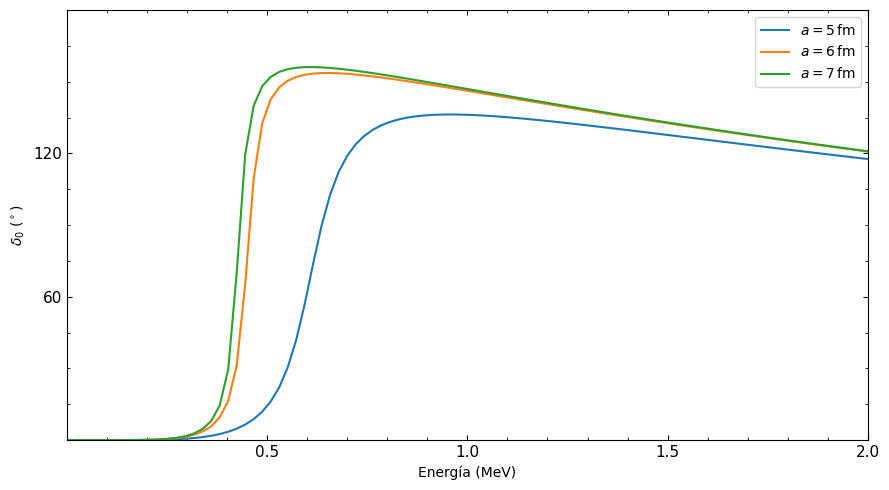

In [119]:
E_vals = np.linspace(1e-4, 2.1, 100)

def calcular_delta_para_a(a, E_vals, N, l, mu, Z1, Z2, hbar, H, H_prime):
    delta_vals = []
    H_matriz, r, x = build_hamiltonian(N, a)
    f_hat = build_f(N, a)
    for E in E_vals:
        k = np.sqrt(2 * mu * E) / hbar
        eta = (1 / 137) * Z1 * Z2 * np.sqrt(mu / (2 * E))
        ak = a * k
        R_scalar, C_matrix = build_R_matrix(N, E, H_matriz, f_hat, mu, a)
        S_E = S(True, l, eta, ak, R_scalar, C_matrix, H, H_prime)
        delta_l = 0.5 * arg(S_E)
        if delta_l < 0:
            delta_l += np.pi
        delta_vals.append(delta_l)
    return delta_vals
print(f"Valor de N = {N} y l = {l}")
a_vals = [5, 6, 7]
plt.figure(figsize=(9, 5))
for a in a_vals:
    delta_vals = calcular_delta_para_a(a, E_vals, N, l, mu, Z1, Z2, hbar, H, H_prime)
    delta_deg = [np.degrees(float(d)) for d in delta_vals]
    plt.plot(E_vals, delta_deg, label=fr'$a = {a}\,\mathrm{{fm}}$')
plt.xlabel("Energía (MeV)")
plt.ylabel(r"$\delta_0$ ($^\circ$)")
plt.xticks(np.arange(0.5, 2.1, 0.5))
plt.yticks(np.arange(60, 180, 60))
plt.xlim(0, 2)
plt.ylim(0, 180)
plt.tick_params(labelsize=11)
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.minorticks_on()
ax.grid(False, which='minor')
ax.tick_params(direction='in', which='both', bottom=True, left=True, top=True, right=True)
plt.legend()
plt.tight_layout()
plt.show()